In [ ]:
import numpy as np
import cv2
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy.fftpack import fftshift
from scipy.fftpack import ifftshift
from scipy.fftpack import fft2
from scipy.fftpack import ifft2
from math import factorial
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pywt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = "/content/b.jpg"

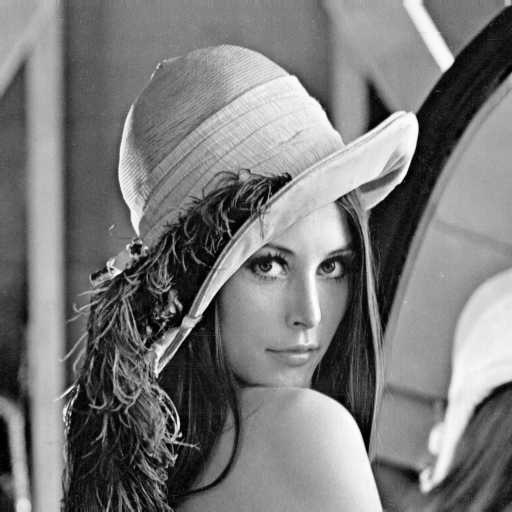

In [ ]:
from google.colab.patches import cv2_imshow
# Read the image
image_bgr = cv2.imread(image_path)
# image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (512, 512))
cv2_imshow(image)

In [ ]:
image.shape

(512, 512)

In [ ]:
import pywt
import numpy as np

def iwt2(coeffs, wavelet='haar'):
    LL, (LH, HL, HH) = coeffs
    coeffs = LL, (LH.astype(np.int32), HL.astype(np.int32), HH.astype(np.int32))
    return pywt.idwt2(coeffs, wavelet)

# Perform DWT
coeffs = pywt.dwt2(image, 'haar')

# Perform IWT
iwt_image = iwt2(coeffs, 'haar')

In [ ]:
len(coeffs)
# coeffs

2

In [ ]:
Ic = coeffs[0]
h = coeffs[1][0]
v = coeffs[1][1]
d = coeffs[1][2]

In [ ]:
print(Ic.shape)
print(h.shape)
print(v.shape)
print(d.shape)

(256, 256)
(256, 256)
(256, 256)
(256, 256)


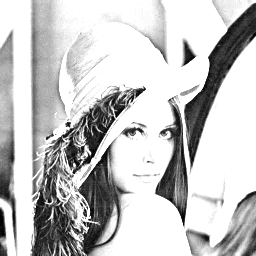

In [ ]:
cv2_imshow(Ic)

In [ ]:
print(image.shape)
# print(image)

(512, 512)


In [ ]:
print(iwt_image.shape)
# print(iwt_image)
# iwt_image_rgb = iwt_image[:, :, :3]
# print(iwt_image_rgb.shape)

(512, 512)


Reconstructed Image using IWT:


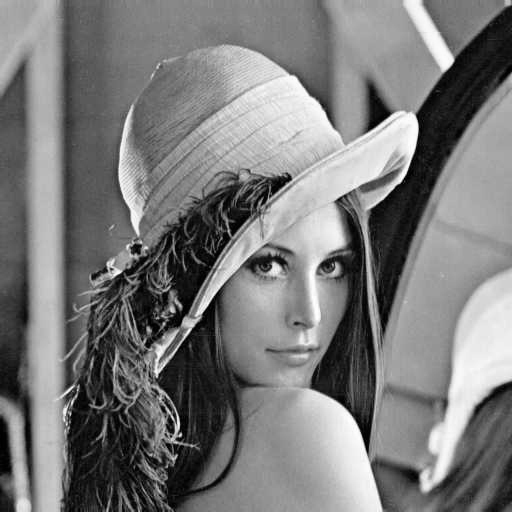

In [ ]:
print("Reconstructed Image using IWT:")
cv2_imshow(iwt_image)

In [ ]:
import numpy as np
import cv2
import math

def zernike_polynomial(p, q, rho, theta):
    """
    Calculate Zernike polynomial value at given (rho, theta) coordinates.
    """
    if (p - abs(q)) % 2 != 0:
        return 0

    result = 0.0
    for c in range((p - abs(q)) // 2 + 1):
        coeff = (-1) ** c * math.factorial(p - c) / (math.factorial(c) * math.factorial((p + abs(q)) // 2 - c) * math.factorial((p - abs(q)) // 2 - c))
        result += coeff * rho ** (p - 2 * c)
    result *= rho ** abs(q)
    result *= np.exp(1j * q * theta)

    return result

def calculate_zernike_moments(image, order_max):
    """
    Calculate Zernike moments up to a given maximum order for a given image.
    """
    h, w = image.shape
    moments = []
    centroid = (h / 2, w / 2)  # centroid of the image

    for p in range(order_max + 1):
        for q in range(-p, p + 1, 2):
            moment = 0.0
            for i in range(h):
                for j in range(w):
                    x, y = j - centroid[1], i - centroid[0]
                    rho = np.sqrt(x ** 2 + y ** 2) / (min(h, w) / 2)
                    if rho <= 1:  # inside the unit circle
                        theta = np.arctan2(y, x)
                        moment += image[i, j] * np.conj(zernike_polynomial(p, q, rho, theta))
            moments.append(moment)
    return moments

# Calculate Zernike moments up to order 5
order_max = 5
zernike_moments = calculate_zernike_moments(Ic, order_max)

# Display the first 10 Zernike moments
print("First 10 Zernike moments:")
for i in range(10):
    print(f"Zernike moment {i + 1}: {zernike_moments[i]}")

First 10 Zernike moments:
Zernike moment 1: (12785097+0j)
Zernike moment 2: (675140.4824305028-278252.2586078422j)
Zernike moment 3: (675140.4824305028+278252.2586078422j)
Zernike moment 4: (94113.17537693866+413863.8689993471j)
Zernike moment 5: (236675.8784790039+0j)
Zernike moment 6: (94113.17537693866-413863.8689993471j)
Zernike moment 7: (-152262.5299487734+153141.31900685147j)
Zernike moment 8: (134218.44848471286+270255.60763658036j)
Zernike moment 9: (134218.44848471286-270255.60763658036j)
Zernike moment 10: (-152262.5299487734-153141.31900685147j)


In [ ]:
def integer_wavelet_transform(original_image):
    # Perform integer wavelet transform
    coeffs = pywt.dwt2(original_image, 'haar')
    low_frequency_region = coeffs[0]
    return low_frequency_region

def normalize_0_1(image):
    # Ensure input image is a NumPy array
    image = np.array(image)

    # Normalize pixel values to the range [0, 1]
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)

    return normalized_image

# Load the original image
original_image = image

# Step 1: Integer Wavelet Transform and Zernike Moments Calculation
low_frequency_region = integer_wavelet_transform(original_image)
order_max = 2 # Maximum order of Zernike moments
zernike_moments = calculate_zernike_moments(low_frequency_region, order_max)
zernike_moments = normalize_0_1(zernike_moments)

In [ ]:
print(len(zernike_moments))
print(zernike_moments)

6
[1.        +4.58166408e-18j 0.04608215+9.18288737e-03j
 0.04751063+5.29866877e-02j 0.00212468+6.51524281e-02j
 0.01228379+3.22102729e-02j 0.        +0.00000000e+00j]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

import numpy as np

def embed_zernike_moments(zernike_moments, watermark, private_key):
    watermarked_zernike_moments = zernike_moments.copy()

    # Adjust the embedding strength based on the private key
    embedding_strengths = private_key * 0.1  # Adjust this factor as needed

    # Iterate over watermark and private key to select moments and embed watermark
    for i, (wm, key) in enumerate(zip(watermark, private_key)):
        moment_index = i % len(zernike_moments)
        watermarked_zernike_moments[moment_index] += wm * embedding_strengths[i]

    return watermarked_zernike_moments

def reconstruct_watermarked_ic(watermarked_zernike_moments, low_frequency_region):
    # Reconstruct watermarked image from watermarked Zernike moments and low-frequency region
    h, w = low_frequency_region.shape
    watermarked_image = low_frequency_region.copy()

    for p in range(order_max + 1):
        for q in range(-p, p + 1, 2):
            moment = watermarked_zernike_moments[p*(p+1)//2 + (p+q)//2]  # Moment index calculation
            patch = np.zeros((h, w), dtype=np.complex128)  # Initialize patch
            for i in range(h):
                for j in range(w):
                    x, y = j - w / 2, i - h / 2
                    rho = np.sqrt(x ** 2 + y ** 2) / (min(h, w) / 2)
                    if rho <= 1:  # inside the unit circle
                        theta = np.arctan2(y, x)
                        patch[i, j] = moment * zernike_polynomial(p, q, rho, theta)
            watermarked_image += np.real(patch)  # Add the real part of the patch to the image

    # Add the low-frequency region
    watermarked_image += low_frequency_region

    # Normalize the values to the range [0, 1]
    watermarked_image = (watermarked_image - np.min(watermarked_image)) / (np.max(watermarked_image) - np.min(watermarked_image))

    return watermarked_image


def round_and_normalize(image, min_value=0, max_value=255):
    image = np.array(image)
    # Normalize pixel values to the specified range [min_value, max_value]
    normalized_image = ((image - np.min(image)) /
                        (np.max(image) - np.min(image)) *
                        (max_value - min_value) + min_value)
    rounded_normalized_image = np.round(normalized_image).astype(np.uint8)

    return rounded_normalized_image

# Step 2: Selection and Embedding of Low-Order Zernike Moments
watermark = np.random.rand(order_max)  # Random watermark for demonstration
private_key = np.random.rand(order_max)  # Random private key
watermarked_zernike_moments = embed_zernike_moments(zernike_moments, watermark, private_key)
watermarked_zernike_moments = round_and_normalize(watermarked_zernike_moments)

# Step 3: Reconstruct Watermarked Image
watermarked_iwt = reconstruct_watermarked_ic(watermarked_zernike_moments, low_frequency_region)
watermarked_iwt = round_and_normalize(watermarked_iwt)

<ipython-input-55-448b920a6bd8>:51: ComplexWarning: Casting complex values to real discards the imaginary part
  rounded_normalized_image = np.round(normalized_image).astype(np.uint8)


In [ ]:
print(watermark)
print(private_key)

[0.90578603 0.42513514]
[0.98262151 0.39437027]


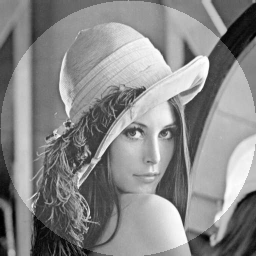

In [ ]:
cv2_imshow(watermarked_iwt)

In [ ]:
coeffs = watermarked_iwt, (h,v,d)
watermarked_image_iw = iwt2(coeffs, 'haar')
watermarked_image_iw = round_and_normalize(watermarked_image_iw)

(512, 512)


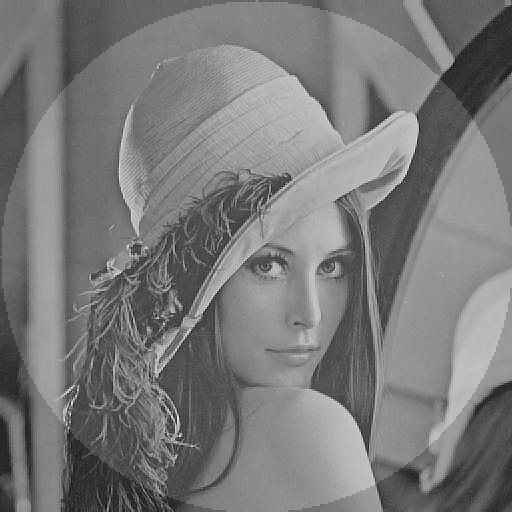

In [ ]:
print(watermarked_image_iw.shape)
cv2_imshow(watermarked_image_iw)

In [ ]:
def record_errors(original_image, watermarked_image):
    # Calculate errors caused by watermark embedding
    errors = original_image.astype(float) - watermarked_image.astype(float)

    # Embed errors into watermarked image
    watermarked_image_with_errors = watermarked_image + errors
    return watermarked_image_with_errors, errors

# Assuming original_image and watermarked_image_iw are defined earlier
watermarked_image_with_errors, errors = record_errors(original_image, watermarked_image_iw)

[[ 51.  51.  51. ...  57.  32.  40.]
 [ 52.  52.  51. ...  59.  30.  38.]
 [ 53.  53.  52. ...  58.  34.  41.]
 ...
 [-29. -29. -28. ...   7.   6.   7.]
 [-29. -29. -27. ...  10.  13.  13.]
 [-29. -28. -27. ...  11.  11.  13.]]


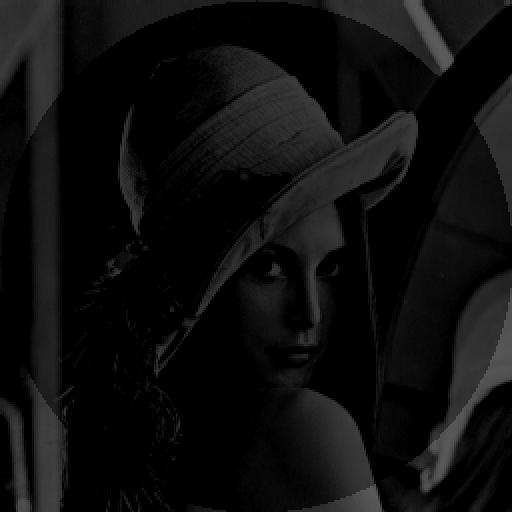

In [ ]:
print(errors)
cv2_imshow(errors)

In [ ]:
import hashlib

def calculate_hash(image):
    # Calculate hash value of the image
    hash_value = hashlib.sha256(image).hexdigest()
    return hash_value

# Assuming watermarked_image_iw is defined elsewhere in your code
# Calculate hash value for watermarked image
hash_value = calculate_hash(watermarked_image_iw)
print(hash_value)


807b089637d6afd7355d4d85c569e007ffbee6da940ef5e47c2e0b3687d01966


In [ ]:
def embed_auxiliary_information(watermarked_image_with_errors, hash_value):
    # Embed hash value into the watermarked image
    hash_bytes = bytes.fromhex(hash_value)
    hash_array = np.frombuffer(hash_bytes, dtype=np.uint8)
    reversible_watermarked_image = np.concatenate((watermarked_image_with_errors.flatten(), hash_array))
    return reversible_watermarked_image

# Embed hash value into the watermarked image with errors
reversible_watermarked_image = embed_auxiliary_information(watermarked_image_with_errors, hash_value)

In [ ]:
import binascii

def restore_original_image(reversible_watermarked_image, original_image_shape):
    # Extract watermark and hash value from the reversible watermarked image
    watermark_length = 32  # Assuming the length of the hash value is 32 bytes
    watermarked_image_with_errors = reversible_watermarked_image[:-watermark_length].reshape(original_image_shape)
    hash_bytes = reversible_watermarked_image[-watermark_length:]

    # Decode hash bytes to hexadecimal string
    hash_value = hashlib.sha256(hash_bytes).hexdigest()

    # Restore original image using watermarked image with errors
    restored_image = watermarked_image_with_errors - errors  # Subtract errors to restore original image
    return restored_image, hash_value

# Restore original image and hash value from reversible watermarked image
restored_image, hash_value = restore_original_image(reversible_watermarked_image, (512,512))

In [ ]:
print(hash_value)

0c0176c31a2e676c5624626e9d370370236252813a25af6250375867ed209472


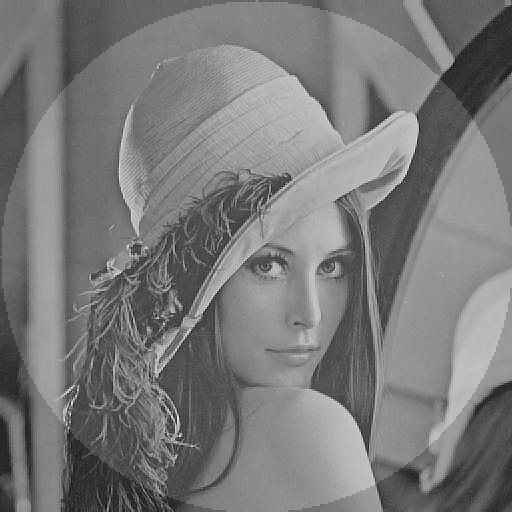

In [ ]:
cv2_imshow(restored_image)

In [ ]:


def calculate_psnr(original, watermarked):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original image and the watermarked image.

    Parameters:
        original (numpy.ndarray): The original image.
        watermarked (numpy.ndarray): The watermarked image.

    Returns:
        float: The PSNR value.
    """
    # Calculate the Mean Squared Error (MSE) between the two images
    mse = np.mean((original - watermarked) ** 2)

    # If the MSE is zero, the images are identical, return infinity as PSNR
    if mse == 0:
        return float('inf')

    # Calculate the maximum possible pixel value in the image
    max_pixel_value = 255.0  # For images with 8-bit depth

    # Calculate the PSNR value
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

# Load the original image and watermarked image using OpenCV
original_image_path = '/content/drive/MyDrive/digital final image/original(8).png'
watermarked_image_path = '/content/drive/MyDrive/digital final image/watermarked (8).png'
original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
watermarked_image = cv2.imread(watermarked_image_path, cv2.IMREAD_GRAYSCALE)

# Calculate the PSNR value
psnr_value = calculate_psnr(original_image, watermarked_image)
print(f"PSNR value between the original and watermarked image: {psnr_value:.2f} dB")


PSNR value between the original and watermarked image: 28.26 dB


In [ ]:


def calculate_ncc(original, watermarked):
    """
    Calculate the Normalized Cross-Correlation (NCC) between the original image and the watermarked image.

    Parameters:
        original (numpy.ndarray): The original image.
        watermarked (numpy.ndarray): The watermarked image.

    Returns:
        float: The NCC value.
    """
    # Flatten the images to 1D arrays
    original_flat = original.flatten()
    watermarked_flat = watermarked.flatten()

    # Calculate the mean of each image
    mean_original = np.mean(original_flat)
    mean_watermarked = np.mean(watermarked_flat)

    # Calculate the numerator of the NCC formula
    numerator = np.sum((original_flat - mean_original) * (watermarked_flat - mean_watermarked))

    # Calculate the denominator of the NCC formula
    denominator = np.sqrt(np.sum((original_flat - mean_original) ** 2) * np.sum((watermarked_flat - mean_watermarked) ** 2))

    # Calculate the NCC value
    if denominator == 0:
        return 0  # Avoid division by zero
    else:
        ncc = numerator / denominator
        return ncc

# Load the original image and watermarked image using OpenCV
original_image_path = '/content/drive/MyDrive/digital final image/original(8).png'
watermarked_image_path = '/content/drive/MyDrive/digital final image/watermarked (8).png'
original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
watermarked_image = cv2.imread(watermarked_image_path, cv2.IMREAD_GRAYSCALE)

# Calculate the NCC value
ncc_value = calculate_ncc(original_image, watermarked_image)
print(f"NCC value between the original and watermarked image: {ncc_value:.4f}")


NCC value between the original and watermarked image: 0.9201
